In [2]:
import sys, os
from typing import Union 

import numpy as np
from pathlib import Path
import subprocess
sys.path.append(os.path.join(os.getcwd(), '../../'))
from ext.lab2im import utils
from SynthSeg.brain_generator import BrainGenerator

# import tensorflow as tf
# print(tf.__version__)  # Should print 2.2.0

# from tensorflow import keras
# print(keras.__version__)  # Should match tf.__version__.

Using TensorFlow backend.


DeepNeuro subject processing - experiment on CBE7

In [3]:
data_dir = '/mnt/hdd0/MRI_data/deepneuro/CBE7/UCSF_3T/flywheel_20250410_201308/flywheel/deepneuro/weil_pilot/'
subject_name = 'DN-00-CBE7'
subject_dir = os.path.join(data_dir,subject_name)
subject_sessions = os.listdir(subject_dir)
subject_sessions = [os.path.join(subject_dir, s) for s in subject_sessions if 'UCSF (3T)' in s]
subject_session = subject_sessions[0]
subject_acquisitions = os.listdir(subject_session)

In [4]:
keyword =  '3D_T1_GRE'
subject_images = [os.path.join(subject_session, s) for s in subject_acquisitions if keyword in s]
img_dir = subject_images[0]
img_path = [im for im in os.listdir(img_dir) if 'nii.gz' in im][0]
img_path = os.path.join(img_dir, img_path)

In [5]:
img_path

'/mnt/hdd0/MRI_data/deepneuro/CBE7/UCSF_3T/flywheel_20250410_201308/flywheel/deepneuro/weil_pilot/DN-00-CBE7/at UCSF (3T) on 2022-12-07/4 - 3D_T1_GRE/3D_T1_GRE_4.nii.gz'

In [7]:
command = 'mri_synthseg --i "' + img_path + '" --o ' + os.path.join(data_dir, subject_name, 'segmentation') + ' --cpu'
subprocess.run(command, shell=True)

SynthSeg 2.0
using CPU, hiding all CUDA_VISIBLE_DEVICES
using 1 thread
predicting 1/1
1/1 [==============================] - 80s 80s/step

segmentation  saved in:    /mnt/hdd0/MRI_data/deepneuro/CBE7/UCSF_3T/flywheel_20250410_201308/flywheel/deepneuro/weil_pilot/DN-00-CBE7/segmentation/3D_T1_GRE_4_synthseg.nii.gz

If you use this tool in a publication, please cite:
SynthSeg: Segmentation of brain MRI scans of any contrast and resolution without retraining
B. Billot, D.N. Greve, O. Puonti, A. Thielscher, K. Van Leemput, B. Fischl, A.V. Dalca, J.E. Iglesias
Medical Image Analysis, accepted for publication.


CompletedProcess(args='mri_synthseg --i "/mnt/hdd0/MRI_data/deepneuro/CBE7/UCSF_3T/flywheel_20250410_201308/flywheel/deepneuro/weil_pilot/DN-00-CBE7/at UCSF (3T) on 2022-12-07/4 - 3D_T1_GRE/3D_T1_GRE_4.nii.gz" --o /mnt/hdd0/MRI_data/deepneuro/CBE7/UCSF_3T/flywheel_20250410_201308/flywheel/deepneuro/weil_pilot/DN-00-CBE7/segmentation --cpu', returncode=0)

In [6]:

def calculate_ir_signal(
    A: float,
    PD: Union[np.ndarray, float], # Use Union for older Python
    TE: float,
    T2: Union[np.ndarray, float], # Use Union for older Python
    TI: float,
    T1: Union[np.ndarray, float], # Use Union for older Python
    TR: float,
    B1: Union[np.ndarray, float], # Use Union for older Python
    theta: float, # Inversion pulse nominal angle (in radians)
    alpha: float, # Excitation pulse nominal angle (in radians)
    epsilon: float = 1e-9 # Small value to prevent potential division by zero
) -> Union[np.ndarray, float]: # Use Union for older Python
   
    # Calculate angles affected by B1 inhomogeneity
    actual_theta = B1 * theta
    actual_alpha = B1 * alpha

    # Calculate exponential terms 
    # Adding epsilon prevents immediate division by zero if T1/T2 is exactly 0,
    # but negative T1/T2 can still cause issues (exp(positive) -> inf).
    E1 = np.exp(-TR / (T1 + epsilon))
    if TI == 0:
        E_TI = 0
    else:
        E_TI = np.exp(-TI / (T1 + epsilon))
    E2 = np.exp(-TE / (T2 + epsilon))

    # Calculate numerator and denominator
    cos_actual_theta = np.cos(actual_theta)
    numerator = 1.0 - (1.0 - cos_actual_theta) * E_TI - cos_actual_theta * E1

    cos_actual_alpha = np.cos(actual_alpha)
    denominator = 1.0 - cos_actual_alpha * cos_actual_theta * E1
    
    # --- NO MASKING - Direct Calculation ---
    # Note: If denominator is zero or near-zero, this will result in inf or NaN.
    # If T1 or T2 were negative, E1, E_TI or E2 might be inf, also leading to inf/NaN.
    signal = A * PD * E2 * (numerator / (denominator + epsilon)) # Add epsilon to final denom too

    return signal

In [7]:
#read dicom with pydicom
import nibabel as nib
import glob
import matplotlib.pyplot as plt


In [8]:
subject_dir

'/mnt/hdd0/MRI_data/deepneuro/CBE7/UCSF_3T/flywheel_20250410_201308/flywheel/deepneuro/weil_pilot/DN-00-CBE7'

In [9]:
nii_path = glob.glob(os.path.join(subject_dir, '*.nii*'))[0]

In [10]:
nii = nib.load(nii_path)

In [11]:
T1map = nii.get_fdata()[:,:,:,0]
T2map = nii.get_fdata()[:,:,:,1]
PDmap = nii.get_fdata()[:,:,:,2]

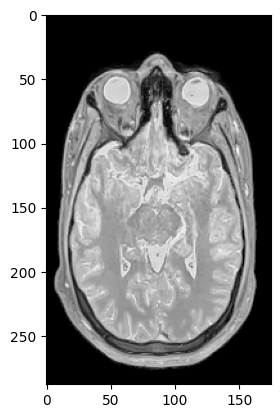

In [12]:
plt.imshow(PDmap[:,140,:],cmap='gray')

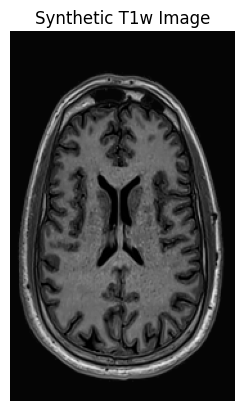

In [15]:
#simulate T1w image

params = {
    'T1': T1map,
    'T2': T2map,
    'PD': PDmap,
    'A': 1.0,         # Scaling factor
    'TE': 2.604,       # Echo Time (ms)
    'TI': 1000.0,     # Inversion Time (ms)
    'TR': 2507.47,     # Repetition Time (ms)
    'B1': 1.0,        # Assume ideal B1 field
    'theta': np.pi,   # Ideal 180-degree inversion pulse
    'alpha': np.pi/18, # flip angle is 10 degrees
}

sT1w = calculate_ir_signal(**params)
plt.imshow(sT1w[:,170,:],cmap='gray')
plt.title('Synthetic T1w Image')
plt.axis('off')
plt.show()

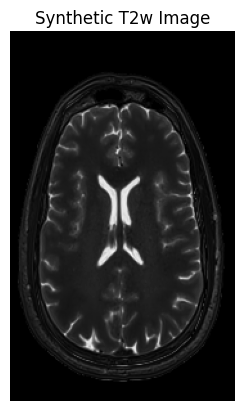

In [16]:
#simulate T2 FLAIR FSat image

params = {
    'T1': T1map,
    'T2': T2map,
    'PD': PDmap,
    'A': 1.0,         # Scaling factor
    'TE': 97.084,       # Echo Time (ms)
    'TI': 0.0,     # Inversion Time (ms)
    'TR': 4890,     # Repetition Time (ms)
    'B1': 1.0,        # Assume ideal B1 field
    'theta': np.pi,   # Ideal 180-degree inversion pulse
    'alpha': np.pi*(180/115), # flip angle is 90 degrees
    # 'epsilon': 0
}

sT1w = calculate_ir_signal(**params)
plt.imshow(sT1w[:,170,:],cmap='gray')
plt.title('Synthetic T2w Image')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Synthetic T2 FLAIR Image')

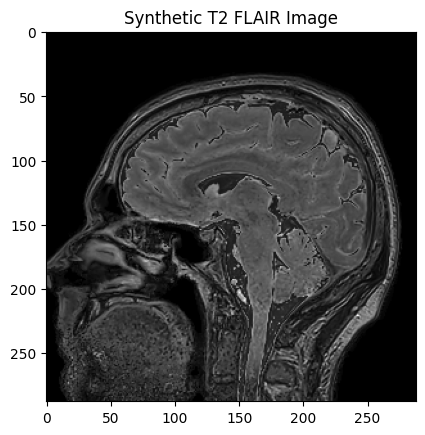

In [28]:
#simulate T2 FLAIR FSat image

params = {
    'T1': T1map,
    'T2': T2map,
    'PD': PDmap,
    'A': 1.0,         # Scaling factor
    'TE': 90,       # Echo Time (ms)
    'TI': 3150,     # Inversion Time (ms)
    'TR': 15000,     # Repetition Time (ms)
    'B1': 1.0,        # Assume ideal B1 field
    'theta': np.pi,   # Ideal 180-degree inversion pulse
    'alpha': np.pi/2, # flip angle is 90 degrees
}

sT1w = calculate_ir_signal(**params)
plt.imshow(np.flipud(sT1w[:,:,90].T), cmap='gray')
plt.title('Synthetic T2 FLAIR Image')